<a href="https://colab.research.google.com/github/afif-af/ml_pytorch_scikitlearn/blob/main/Chapter07ml_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
  k_start=int(math.ceil(n_classifier/2.))
  probs=[comb(n_classifier, k) * error **k *
          (1-error)**(n_classifier -k)
          for k in range(k_start, n_classifier +1)]
  return sum(probs)


In [26]:
ensemble_error(n_classifier=11, error=0.25)

np.float64(0.03432750701904297)

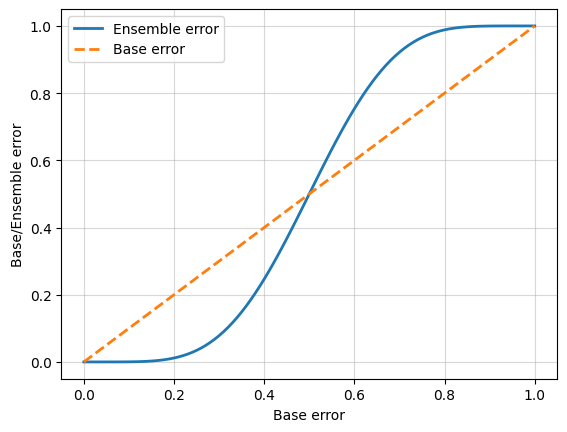

In [27]:

import numpy as np
import matplotlib.pyplot as plt
error_range=np.arange(0.0, 1.01, 0.01)
ens_errors =[ensemble_error(n_classifier=11, error=error)
             for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--',label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [28]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
             weights=[0.2,0.2,0.6]))



np.int64(1)

In [29]:
ex=np.array([[0.9, 0.1],
             [0.8, 0.2],
             [0.4, 0.6]])
p=np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [30]:
np.argmax(p)

np.int64(0)

In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    # ✅ Tell sklearn this is a classifier
    _estimator_type = "classifier"
    __sklearn_is_fitted__ = True

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key, value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Number of classifiers and weights must be equal")

        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # vote by class label
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        return self.lablenc_.inverse_transform(maj_vote)

    def predict_proba(self, X):
        probas = np.asarray([
            clf.predict_proba(X) for clf in self.classifiers_
        ])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


In [32]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris=datasets.load_iris()
X, y= iris.data[50:, [1,2]], iris.target[50:]
le=LabelEncoder()
y=le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=1,
                                                    stratify=y)

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1,
                          solver='lbfgs')
clf2=DecisionTreeClassifier(max_depth=1,
                            criterion='entropy',
                            random_state=0)
clf3=KNeighborsClassifier(n_neighbors=1,
                          p=2,
                          metric='minkowski')

pipe1=Pipeline([['sc', StandardScaler()],
                ['clf', clf1]])
pipe3=Pipeline([['sc', StandardScaler()],
                ['clf', clf3]])
clf_labels=['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='roc_auc')
  print(f'ROC AUC: {scores.mean():.2f}'
  f'(+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92(+/- 0.15) [Logistic regression]
ROC AUC: 0.87(+/- 0.18) [Decision tree]
ROC AUC: 0.85(+/- 0.13) [KNN]


In [34]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f}'
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92(+/- 0.15) [Logistic regression]
ROC AUC: 0.87(+/- 0.18) [Decision tree]
ROC AUC: 0.85(+/- 0.13) [KNN]
ROC AUC: nan(+/- nan) [Majority voting]


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: MajorityVoteClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be '

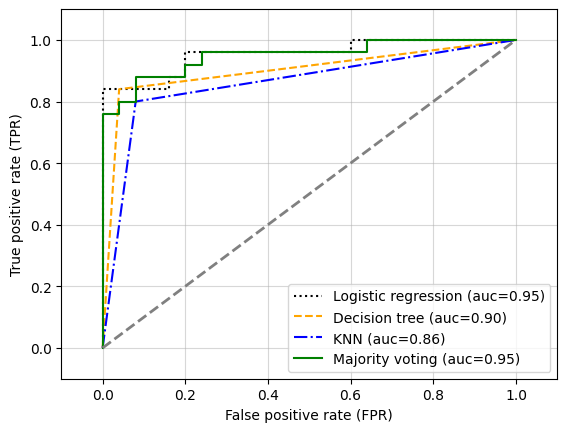

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors=['black','orange','blue','green']
linestyles=[':','--','-.','-']
for clf, label, clr, ls \
    in zip (all_clf, clf_labels, colors, linestyles):
    y_pred=clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fbr, tpr, thresholds=roc_curve(y_true=y_test,
                                   y_score=y_pred)
    roc_auc=auc(x=fbr, y=tpr)
    plt.plot(fbr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc={roc_auc:.2f})')
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()


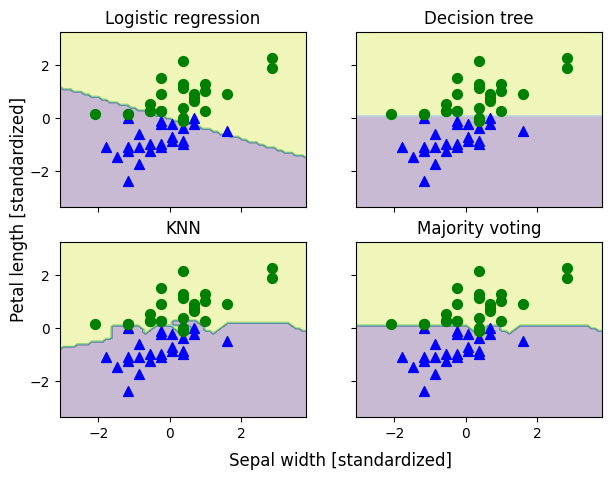

In [36]:
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
from itertools import product
x_min=X_train_std[:, 0].min()-1
x_max=X_train_std[:, 0].max()+1
y_min=X_train_std[:, 1].min()-1
y_max=X_train_std[:, 1].max()+1

xx, yy=np.meshgrid(np.arange(x_min, x_max, 0.1),
                   np.arange(y_min, y_max, 0.1))
f, axarr=plt.subplots(nrows=2, ncols=2,
                      sharex='col',
                      sharey='row',
                      figsize=(7,5))
for idx, clf, tt in zip(product([0,1],[0,1]),
                        all_clf, clf_labels):
  clf.fit(X_train_std, y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^',
                                s=50)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)
  axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5, s='Sepal width [standardized]',ha='center',va='center',fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]',ha='center', va='center',fontsize=12, rotation=90)
plt.show()

In [37]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [38]:
from sklearn.model_selection import GridSearchCV

params={'decisiontreeclassifier__max_depth':[1, 2],
        'pipeline-1__clf__C':[0.001, 0.1, 100.0]}
grid=GridSearchCV(estimator=mv_clf,
                  param_grid=params,
                  cv=10,
                  scoring='roc_auc')
grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [39]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [40]:
print(f'Best parameters:{grid.best_params_}')

Best parameters:{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [41]:
print(f'ROC AUC: {grid.best_score_:.2f}')

ROC AUC: nan


#Bagging

In [42]:
import pandas as pd
df_wine=pd.read_csv('https://archive.ics.uci.edu/ml/'
                    'machine-learning-databases/'
                    'wine/wine.data',
                    header=None)
df_wine.columns=['Class label', 'Alcohol',
 'Malic acid', 'Ash',
 'Alcalinity of ash',
 'Magnesium', 'Total phenols',
 'Flavanoids', 'Nonflavanoid phenols',
 'Proanthocyanins',
 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines',
 'Proline']


In [43]:
df_wine=df_wine[df_wine['Class label'] !=1]
y=df_wine['Class label'].values
X=df_wine[['Alcohol',
           'OD280/OD315 of diluted wines']].values

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le=LabelEncoder()
y=le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(criterion='entropy',
                            random_state=1,
                            max_depth=None)
bag=BaggingClassifier(estimator=tree,
                      n_estimators=500,
                      max_samples=1.0,
                      max_features=1.0,
                      bootstrap=True,
                      bootstrap_features=False,
                      n_jobs=-1,
                      random_state=1)

In [46]:
from sklearn.metrics import accuracy_score
tree=tree.fit(X_train, y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
tree_train=accuracy_score(y_train, y_train_pred)
tree_test=accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies: 1.000/0.833


In [47]:
bag=bag.fit(X_train, y_train)
y_train_pred=bag.predict(X_train)
y_test_pred=bag.predict(X_test)
bag_train=accuracy_score(y_train, y_train_pred)
bag_test=accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies: {bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies: 1.000/0.917


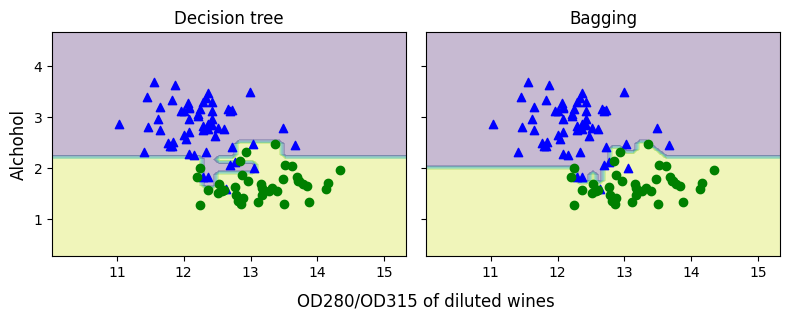

In [48]:
x_min=X_train[:, 0].min()-1
x_max=X_train[:, 0].max()+1
y_min=X_train[:, 1].min()-1
y_max=X_train[:, 1].max()+1
xx, yy=np.meshgrid(np.arange(x_min, x_max, 0.1),
                   np.arange(y_min, y_max, 0.1))
f, axarr =plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8,3))
for idx, clf, tt in zip([0,1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
  clf.fit(X_train, y_train)
  Z= clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue',
                     marker='^')
  axarr[idx].scatter(X_train[y_train==1,0],
                     X_train[y_train==1,1],
                     c='green', marker='o')
  axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alchohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12, transform=axarr[1].transAxes)
plt.show()

In [50]:
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct=(y==yhat)
weights = np.full(10, 0.1)
print(weights)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [51]:
epsilon=np.mean(~correct)
print(epsilon)

0.3


In [52]:
alpha_j=0.5 * np.log((1-epsilon)/epsilon)

In [53]:
print(alpha_j)

0.42364893019360184


In [56]:
update_if_correct =0.1 * np.exp(-alpha_j * 1 *1)
print(update_if_correct)

0.06546536707079771


In [57]:
update_if_wrong_1=0.1 *np.exp(-alpha_j * 1 *-1)

In [58]:
print(update_if_wrong_1)

0.1527525231651947


In [59]:
update_if_wrong_2=0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_2)

0.1527525231651947


In [60]:
weights=np.where(correct==1,
                 update_if_correct,
                 update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [61]:
normalized_weights=weights/np.sum(weights)

In [62]:
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


In [64]:
from sklearn.ensemble import AdaBoostClassifier
tree=DecisionTreeClassifier(criterion='entropy',
                            random_state=1,
                            max_depth=1)
ada=AdaBoostClassifier(estimator=tree,
                        n_estimators=500,
                       learning_rate=0.1,
                       random_state=1)
tree=tree.fit(X_train, y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
tree_train=accuracy_score(y_train, y_train_pred)
tree_test=accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies: 0.916/0.875


In [65]:
ada=ada.fit(X_train, y_train)
y_train_pred=ada.predict(X_train)
y_test_pred=ada.predict(X_test)
ada_train=accuracy_score(y_train, y_train_pred)
ada_test=accuracy_score(y_test, y_test_pred)
print(f'AdaBoost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}')


AdaBoost train/test accuracies: 0.968/0.917


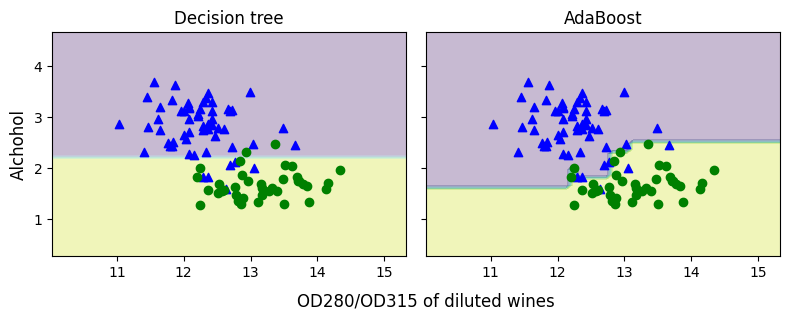

In [67]:
x_min=X_train[:, 0].min()-1
x_max=X_train[:, 0].max()+1
y_min=X_train[:, 1].min()-1
y_max=X_train[:, 1].max()+1
xx, yy=np.meshgrid(np.arange(x_min, x_max, 0.1),
                   np.arange(y_min, y_max, 0.1))
f, axarr =plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8,3))
for idx, clf, tt in zip([0,1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
  clf.fit(X_train, y_train)
  Z= clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue',
                     marker='^')
  axarr[idx].scatter(X_train[y_train==1,0],
                     X_train[y_train==1,1],
                     c='green', marker='o')
  axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alchohol', fontsize=12)
plt.tight_layout()
plt.text(0,
         -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)
plt.show()

In [70]:
import xgboost as xgb
model=xgb.XGBClassifier(n_estimators=1000,
                        learning_rate=0.01,
                        max_depth=4,random_state=1,
                        use_label_encoder=False)
gbm=model.fit(X_train, y_train)
y_train_pred=gbm.predict(X_train)
y_test_pred=gbm.predict(X_test)

gbm_train=accuracy_score(y_train, y_train_pred)
gbm_test=accuracy_score(y_test, y_test_pred)
print(f'XGBoost train/test accuracies: {gbm_train:.3f}/{gbm_test:.3f}')

XGBoost train/test accuracies: 0.968/0.917
